# Implementing a ReAct Agent with Router

In [43]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY') # type: ignore

In [44]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage 
from langchain_core.tools import tool

## 1 - Define the state

In [45]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

## 2 - Create tools

In [46]:
@tool
def find_contacts() -> list[str]:
    """ Gets the contacts from the database """
    return [ "Diego Jr.", "Angelica", "Alessa", "Papa", "Mama"]

@tool
def send_email(contact: str, body: str) -> str:
    """ Sends an email to contact """
    return f"Email sent to {contact} with {body}"

@tool
def create_calendar_event(title: str, date: str, time: str) -> str:
    """ Create a calendar event """
    return f"Created an event '{title}' on {date} at {time}"

## 3 -  Create the agent nodes

In [47]:
def call_agent(state: AgentState) -> AgentState:
    llm = ChatGroq(model = "llama-3.3-70b-versatile")
    tools = [find_contacts, send_email, create_calendar_event]
    llm_with_tools = llm.bind_tools(tools)

    messages = state["messages"]
    response = llm_with_tools.invoke(messages)

    return { "messages": [response] }

def execute_tools(state: AgentState) -> AgentState:
    tools = [find_contacts, send_email, create_calendar_event]
    tool_map = { tool.name: tool for tool in tools }

    last_message = state["messages"][-1]
    tool_calls = last_message.tool_calls

    tool_messages = []

    print(tool_messages)
    for tool_call in tool_calls:
       tool = tool_map[tool_call['name']]
       result = tool.invoke(tool_call['args'])
        
       tool_messages.append({
            "role": "tool",
            "content": str(result),
            "tool_call_id": tool_call['id']
       })
    
    return { "messages": tool_messages }

## 4 - Creating a routing

Defines what to do next

In [48]:
from typing import Literal

def should_continue(state: AgentState) -> Literal["tools", "end"]:
    last_message = state["messages"][-1]
    tool_calls = getattr(last_message, 'tool_calls', None)
    
    if tool_calls and len(tool_calls) > 0:  # ✅ Better validation
        return "tools"
    
    return "end"

## 5 - Creating the Graph

In [49]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", call_agent)
workflow.add_node("tools", execute_tools)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools", ## --> Goes to the tool node
        "end": END ## --> Goes to END node and Finish the flow
    }
)
## If required, go back from tools to agent
workflow.add_edge("tools", "agent")

graph = workflow.compile()

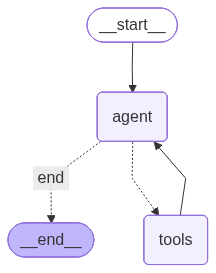

In [50]:
from IPython.display import Image,display
## Display
display(Image(graph.get_graph().draw_mermaid_png()))

## 6 - Invoking the agent

In [52]:
result = graph.invoke({
    "messages": [
        HumanMessage(
            content=
            """
            Envia un correo a polo que su correo es polo@gmail.com de que no podre verlo hoy.
            
            
            Despues busca en mis contactos y enviale a cada contacto el siguiente correo:
            ```
            Hola <contact> espero que estes bien recuerda que te quiero mucho
            ```
            Reemplaza <contact> por el contacto encontrado

            Despues crea un evento en mi calendario para ver a rodrigo el siguiente 10 de Octubre del 2025
            a las 02:00 pm y despues enviale un correo a rodrigo a su correo rodrigo@hotmail.com comentandole
            que si podemos vernos a la fecha y hora en la que hice el evento.
            """
        )
    ]
})

for message in result["messages"]:
    print(f"{message.type}: {message.content}")

[]
[]
human: 
            Envia un correo a polo que su correo es polo@gmail.com de que no podre verlo hoy.


            Despues busca en mis contactos y enviale a cada contacto el siguiente correo:
            ```
            Hola <contact> espero que estes bien recuerda que te quiero mucho
            ```
            Reemplaza <contact> por el contacto encontrado

            Despues crea un evento en mi calendario para ver a rodrigo el siguiente 10 de Octubre del 2025
            a las 02:00 pm y despues enviale un correo a rodrigo a su correo rodrigo@hotmail.com comentandole
            que si podemos vernos a la fecha y hora en la que hice el evento.
            
ai: 
tool: Email sent to polo@gmail.com with No podré verlo hoy
tool: ['Diego Jr.', 'Angelica', 'Alessa', 'Papa', 'Mama']
tool: Email sent to rodrigo@hotmail.com with Hola rodrigo espero que estes bien recuerda que te quiero mucho
tool: Created an event 'Ver a Rodrigo' on 10 Octubre 2025 at 02:00 pm
tool: Email sent to r